# 8. Recurrent Neural Networks


So far we encountered two types of data: generic vectors and images. **For the latter we designed specialized layers to take advantage of the regularity properties in them**. In other words, if we were to permute the pixels in an image, it would be much more difficult to reason about its content of something that would look much like the background of a test pattern in the times of analog TV.

Most importantly, so far we tacitly assumed that our data is generated i.i.d., i.e., independently and identically distributed, all drawn from some distribution. **Unfortunately, this is not true for most data. For instance, the words in this paragraph are written in sequence, and it would be quite difficult to decipher its meaning if they were permuted randomly. Likewise, image frames in a video, the audio signal in a conversation, or the browsing behavior on a website, all follow sequential order**. It is thus only reasonable to assume that specialized models for such data will do better at describing it and at solving estimation problems.
Another issue arises from the fact that we might not only receive a sequence as an input but rather might be expected to continue the sequence. For instance, the task could be to continue the series 2, 4, 6, 8, 10, ... This is quite common in time series analysis, to predict the stock market, the fever curve of a patient or the acceleration needed for a race car. Again we want to have models that can handle such data.

In short, while convolutional neural networks can efficiently process spatial information, recurrent neural networks are designed to better handle sequential information. **These networks introduce state variables to store past information, and then determine the current outputs, together with the current inputs**.
Many of the examples for using recurrent networks are based on text data. Hence, we will emphasize language models in this chapter. After a more formal review of sequence data we discuss basic concepts of a language model and use this discussion as the inspiration for the design of recurrent neural networks. Next, we describe the gradient calculation method in recurrent neural networks to explore problems that may be encountered in recurrent neural network training.


## 8.1 Sequence Models


Imagine that you are watching movies on Netflix. As a good Netflix user, you decide to rate each of the movies religiously. After all, a good movie is a good movie, and you want to watch more of them, right? **As it turns out, things are not quite so simple. Peopleʼs opinions on movies can change quite significantly over time. In fact, psychologists even have names for some of the effects**:

- There is anchoring, based on someone else's opinion. For instance after the Oscar awards, ratings for the corresponding movie go up, even though it is still the same movie. This effect persists for a few months until the award is forgotten. Research showed that the effect lifts rating by over half a point

- There is Hedonic adaptation, where humans quickly adapt to accept an improved (or a bad) situation as the new normal. For instance, after watching many good movies, the expectations that the next movie is equally good or better are high, hence even an average movie might be considered a bad movie after many great ones.

- There is seasonality. Very few viewers like to watch Santa Claus movie in August.

- In some cases movies become unpopular due to misbehaviors of directors or actors in the production.

- Some movies become cult movies, because they were almost comically bad. *Plan 9 from Outer Space* and *Troll 2* achieved a high degree of notoriety for this reason.

In short **ratings are anything but stationary**. Using temporal dynamics helped to recommend movies more accurately. But it is not just about movies.

- Many users have highly particular behavior when it comes to the time when they open apps. For instance, social media apps are much more popular after school with students. Stock market trading apps are more commonly used when the markets are open.

- It is much harder to predict tomorrow's stock prices than to fill in the blanks for a stock price we missed yesterday, even though both are just a matter of estimating one number. After all, **hindsight is so much easier than foresight**. In statistics the former is called *extrapolation* whereas the latter is called *interpolation*.

- Music, speech, text, movies, steps, etc. are all sequential in nature. If we were to permute them they would make little sense. The headline dog bites man is much less surprising than man bites dog, even though the words are identical.

- Earthquakes are strongly correlated, i.e., after a massive earthquake there are very likely several smaller aftershocks, much more so than without the strong quake. In fact, earthquakes are spatiotemporally correlated, i.e., the aftershocks typically occur within a short time span and in close proximity.

- Humans interact with each other in a sequential nature, as can be seen in Twitter fights, dance patterns and debates.

#### 8.1.1 Statistical Tools

In short, we need statistical tools and new deep neural networks architectures to deal with sequence data. To keep things simple, we use the stock price illustrated in Fig. 8.1.1 in the book as an example.

Let's denote the prices by $x_t \geq 0$, i.e., at time $t \in N$ we observe some price $x_t$. For a trader to do well in the stock market on day $t$ he should want to predict $x_t$ via

- $x_t \sim p(x_t | x_{t-1}, ..., x_{1})$


#### Autoregressive Models

In order to achieve that, our trader could use a regressor such as the one we trained in the Section on Linear Regression. There is just a major problem: the number of inputs  $x_{t-1}, ..., x_{1}$ **varies, depending on $t$**. That is, the number increases with the amount of data that we encounter, and we will need and approximation to make this computationally tractable. Much of what follows in this chapter will revolve around how to estimate $p(x_t | x_{t-1}, ..., x_{1})$ efficiently. In a nutshell it boils down to two strategies:

- 1) Assume that the potentially rather long sequence $x_{t-1}, ..., x_{1}$ is not **really necessary**. In this case we might content ourselves with some timespan $\tau$ and only use $x_{t-1}, ..., x_{t-\tau}$ observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allows us to train a deep network as indicated above. Such models will be called autoregressive models, as they quite **literally perform regression on themselves**.

- 2) Another strategy, shown in Fig. 8.1.2, is to try and keep some summary $h_{t}$ of the past observations, at the same time update $h_{t}$ in addition to the prediction $\hat{x}_t$. This leads to models that
estimate $x_t$ with $\hat{x}_t = p(x | x_{t-1} ,h_{t})$ and moreover updates of the form $h_t = g(h_{t-1}, x_{t-1})$. **Since $h_{t}$ is never observed, these models are also called latent autoregressive models. LSTMs and GRUs are examples of this.**

Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. **However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the time series itself will not**. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change *stationary*. Regardless of what we do, we will thus get an estimate of the entire time series via

$p(x_1, ..., x_{T}) = \prod p(x_t | x_{t-1}, ..., x_1)$


Note that the above considerations still hold if we deal with discrete objects, such as words, rather than numbers. The only difference is that in such a situation we need to use a classifier rather than a regressor to estimate $p(xt | xt−1, . . . , x1)$.

#### Markov Model

Recall the approximation that in an autoregressive model we use only $(x_{t-1}, ..., x_{t - \tau})$ instead of $(x_{t-1}, ..., x_1)$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a *Markov condition*. In particular, if $\tau = 1$, we have a first order Markov model and $p(x)$ is given by

$p(x_1, ..., x_{T}) = \prod p(x_t | x_{t-1})$

Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $p(x_{t+1} | x_{t-1})$ efficiently using the fact that we only need to take into account a very short history of past observations:

$p(x_{t+1} | x_{t-1}) = \sum p(x_{t+1} | x_t)p(x_t | x_{t-1})$

Going into details of dynamic programming is beyond the scope of this section, but we will introduce it in Section 9.4. Control and reinforcement learning algorithms use such tools extensively.

#### Causality

In principle, there is nothing wrong with unfolding $p(x_1, ..., x_T)$ in reverse order. After all, by conditioning we can always write it via

$p(x_1, ..., x_{T}) = \prod p(x_t | x_{t+1}, ..., x_{T})$

In fact, if we have a Markov model, we can obtain a reverse conditional probability distribution, too. **In many cases, however, there exists a natural direction of the data, namely going forward in time**. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward **but not the converse**. That is, if we change $x_t$, the distribution of past events will not change. Consequently, it ought to be easier to explain $p(x_{t+1} | x_t)$ rather than $p(x_t | x_{t+1})$. For instance, (Hoyer et al., 2009) show that in some cases we can find $x_{t+1} = f(x_t) + \epsilon$ for some additive noise, whereas **the converse is not true**. This is great news, since it is typically the forward direction that we are interested in estimating.

#### 8.1.2 A Toy Example

After so much theory, let's try this out in practice. Let's begin by generating some data. To keep things simple we generate our time series by using a sine function with some additive noise.

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import nn

npx.set_np()

In [2]:
T = 1000
time = np.arange(0, T)

In [5]:
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size = T)

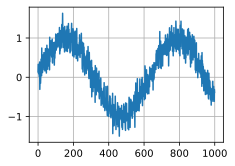

In [12]:
d2l.plot(time, [x])

Next we need to turn this time series into features and labels that the network can train on. Based on the embedding dimension $\tau$ we map the data into pairs $y_t = x_t$ and $z_t = (x_{t-1}, ..., x_{t - \tau})$. The astute reader might have noticed that this gives us τ fewer data points, since we do not have sufficient history for the first τ of them. A simple fix, in particular if the time series is long is to discard those few terms. Alternatively we could pad the time series with zeros. The code below is essentially identical to the training code in previous sections. We kept the architecture fairly simple. A few layers of a fully connected network, ReLU activation and l2 loss. Since much of the modeling is identical to the previous sections when we built regression estimators in Gluon, we will not delve into much detail. 

In [63]:
feat = np.zeros((4,5))

In [13]:
tau = 4
features = np.zeros((T-tau, tau))

In [16]:
for i in range(tau):
    features[:, i] = x[i: T-tau + i]
labels = x[tau:]

In [21]:
batch_size, n_train = 16, 600

train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                           batch_size, is_train = True)
test_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                           batch_size, is_train = False)

In [22]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

In [23]:
loss = gluon.loss.L2Loss()

Now we are ready to train

In [24]:
def train_net(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(1, epochs + 1):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print('epoch %d, loss %f' % (epoch, d2l.evaluate_loss(net, train_iter, loss)))

In [26]:
net = get_net()
train_net(net, train_iter, loss, 10, 0.01)

epoch 1, loss 0.038001
epoch 2, loss 0.027637
epoch 3, loss 0.026744
epoch 4, loss 0.032471
epoch 5, loss 0.026468
epoch 6, loss 0.026309
epoch 7, loss 0.027398
epoch 8, loss 0.027687
epoch 9, loss 0.026339
epoch 10, loss 0.027332


#### 8.1.3 Predictions

Since both training and test loss are small, we would expect our model to work well. Let's see what this means in practice. The first thing to check is how well the model is able to predict what happens in the next timestep.

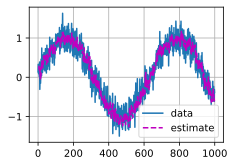

In [27]:
estimates = net(features)

d2l.plot([time, time[tau:]], [x, estimates],
        legend = ['data', 'estimate'])

This looks nice, just as we expected it. Even beyond 600 observations the estimates still look rather trustworthy. There is just one little problem to this: **if we observe data only until timestep 600, we cannot hope to receive the ground truth for all future predictions**. Instead, we need to work our way forward one step at a time:

$x_{601} = f(x_{600}, ..., x_{597})$

$x_{602} = f(x_{601}, ..., x_{598})$

$x_{603} = f(x_{602}, ..., x_{599})$

In other words, we will have to use our own predictions to make future predictions. Let's see how well this goes.

In [35]:
predictions = np.zeros(T)
predictions[:n_train] = x[:n_train]

for i in range(n_train, T):
    predictions[i] = net(
            predictions[(i - tau):i].reshape(1,-1)).reshape(1)

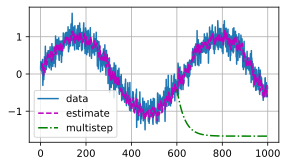

In [36]:
d2l.plot([time, time[tau:], time[n_train:]],
         [x, estimates, predictions[n_train:]],
         legend = ['data', 'estimate', 'multistep'], figsize = (4.5, 2.5))

As the above example shows, this is a spectacular failure. The estimates decay to a constant pretty quickly after a few prediction steps. Why did the algorithm work so poorly? This is ultimately due to the fact that **the errors build up**. Let's say that after step 1 we have some error $\epsilon_1 = \epsilon$. Now the input for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \epsilon + L_{\epsilon_1}$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate, but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let's verify this observation by computing the *k*-step predictions on the entire sequence

In [78]:
k = 33
features = np.zeros((k, T - k))
for i in range(tau):
    features[i] = x[i:T-k+i]
    
for i in range(tau, k):
    features[i] = net(features[(i-tau):i].T).T

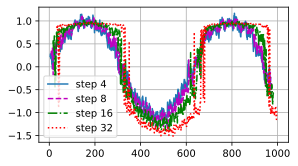

In [42]:
steps = (4,8,16,32)
d2l.plot([time[i:T-k+i] for i in steps], [features[i] for i in steps],
        legend = ['step %d' % i for i in steps], figsize = (4.5, 2.5))

This clearly illustrates how the quality of the estimates changes as we try to predict further into the future. While the 8-step predictions are still pretty good, anything beyonda that is pretty useless.

## 8.2 Text Preprocessing

Text is an important example of sequence data. An article can be simply viewed as a sequence of words, or a sequence of characters. Given text data is a major data format besides images we are using in this book, this section will dedicate to explain the common preproccesing steps for text data. Such preprocessing often consists of four steps:

- 1) Load text as strings into memory
- 2) Split strings into tokens, where a token could be a word or a character
- 3) Build a vocabulary for these tokens to map them into numerical indices
- 4) Map all the tokens in data into indices for ease of feeding into models.

#### 8.2.1 Reading the Dataset

To get started we load text from H.G. Wells' Time Machine. This is a fairly small corpus of just over 30,000 words, but for the purpose of what we want to illustrate this is just fine. More realistic document collections contain many billions of words. The following function reads the dataset into a list of sentences, each sentence is a string. Here we ignore the punctuation and capitalization.

In [80]:
import collections
import d2l
import re

In [81]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                               '090b5e7e70c295757f55df93cb0a180b9691891a')


def read_time_machine():
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line.strip().lower())
            for line in lines]

In [83]:
lines = read_time_machine()
'# Sentences %d' % len(lines)

'# Sentences 3221'

#### 8.2.2 Tokenization

For each sentence, we split it into a list of tokens. **A token is a data point the model will train and predict**. The following function supports splitting a sentence into words or characters, and returns a list of split strings.

In [84]:
def tokenize(lines, token = 'word'):
    if token == 'word':
        return [line.split(' ') for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type ' + token)

In [85]:
tokens = tokenize(lines)
tokens[0:2]

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells', ''], ['']]

#### 8.2.3 Vocabulary

The string type of the token is inconvenient to be used by models, which take numerical inputs. Now letʼs build a dictionary, often called vocabulary as well, **to map string tokens into numerical indices starting from 0. To do so, we first count the unique tokens in all documents, called *corpus*, and then assign a numerical index to each unique token according to its frequency**. Rarely appeared tokens are often removed to reduce the complexity. A token does not exist in corpus or has been removed is mapped into a special unknown (“\<unk>”) token. We optionally add a list of reserved tokens, such as “\<pad>” a token for padding, “\<bos>” to present the beginning for a sentence, and “\<eos>” for the ending of a sentence.

In [87]:
class Vocab(object):
    def __init__(self, tokens, min_freq = 0, reserved_tokens = []):
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key = lambda x: x[0])
        self.token_freqs.sort(key = lambda x: x[1], reverse = True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                       if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
            
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(tokens, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    
def count_corpus(sentences):
    # Flatten a list of token lists into a list of tokens
    tokens = [tk for line in sentences for tk in line]
    return collections.Counter(tokens)

We construct a vocabulary with the time machine dataset as the corpus, and then print the map between a few tokens and their indices.

In [89]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[0:10])

[('<unk>', 0), ('the', 1), ('', 2), ('i', 3), ('and', 4), ('of', 5), ('a', 6), ('to', 7), ('was', 8), ('in', 9)]


After that, we can convert each sentence into a list of numerical indices. To illustrate in detail, we print two sentences with their corresponding indices.

In [90]:
for i in range(8, 10):
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', '']
indices: [1, 20, 72, 17, 38, 12, 120, 43, 706, 7, 660, 5, 112, 2]
words: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
indices: [8, 1654, 6, 3864, 634, 7, 131, 26, 344, 127, 484, 4]


#### 8.2.4 Putting All Things Together

Using the above functions, we package everything into the `load_corpus_time_machine` function, which returns corpus, a list of token indices, and vocab, the vocabulary of the time machine corpus. The modification we did here is that corpus is a single list, not a list of token lists, since we do not keep the sequence information in the following models. Besides, we use character tokens to simplify the training in later sections.

In [95]:
def load_corpus_time_machine(max_tokens =-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[tk] for line in tokens for tk in line]
    if max_tokens > 0: 
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [96]:
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(171489, 28)